In [1]:
import random
import scipy.stats as stats
import pandas as pd
import numpy
import copy

from scipy.stats import poisson
import math

'''
The multinomial CDF function is the implementation of Levin's "Representaion of Multinomial Cumulative Distribution Function"

G:= Number of total groups (including non-protected)
k:= Position
p:= Array of probabilities of each group to be selected
tau_p:= Array of number of protected items

EXAMPLE:
Groups: ["White"(NP), "Black"(P), "Asian"(P), "Hispanic"(P)]
k: 30
p: [0.4, 0.3, 0.2, 0.1]
tau_p: [k, 10, 5, 3]
The ranking is fair if multinomCDF(4, 30, p, tau_p) > a = 0.1 
'''

def multinomCDF_log(G, k, p, tau_p):
    s = float(k);
    log_cdf = -poisson.logpmf(k,s);
    gamma1 = 0.0;
    gamma2 = 0.0;
    sum_s2 = 0.0;
    sum_mu = 0.0;
    
    # P(W=k)
    for i in range(0,G):
        sp = s*p[i];
        
        pcdf = poisson.cdf(tau_p[i],sp);
        log_cdf += numpy.log(pcdf);
        
        mu = sp*(1-poisson.pmf(tau_p[i],sp)/pcdf);
        s2 = mu-(tau_p[i]-mu)*(sp-mu);
        
        mr = tau_p[i];
        mf2 = sp*mu-mr*(sp-mu);
        
        mr *= tau_p[i]-1;
        mf3 = sp*mf2-mr*(sp-mu);
        
        mr *= tau_p[i]-2;
        mf4 = sp*mf3-mr*(sp-mu);
        
        mu2 = mf2+mu*(1-mu);
        mu3 = mf3+mf2*(3-3*mu)+mu*(1+mu*(-3+2*mu));
        mu4 = mf4+mf3*(6-4*mu)+mf2*(7+mu*(-12+6*mu))+mu*(1+mu*(-4+mu*(6-3*mu)));
        
        gamma1 += mu3;
        gamma2 += mu4-3*s2*s2;
        sum_mu += mu;
        sum_s2 += s2; 
    sp = numpy.sqrt(sum_s2);
    gamma1 /= sum_s2*sp;
    gamma2 /= sum_s2*sum_s2;
    
    x = (k-sum_mu)/sp;
    x2 = x*x;
    
    PWN = (-x2/2
    +numpy.log(1+gamma1/6*x*(x2-3)+gamma2/24*(x2*x2-6*x2+3)
    +gamma1*gamma1/72*(((x2-15)*x2+45)*x2-15))
    -numpy.log(2*math.pi)/2 -numpy.log(sp));
    
    log_cdf += PWN;
    return log_cdf;

def multinomCDF(G, k, p, tau_p):
    return numpy.exp(multinomCDF_log(G, k, p, tau_p ));

"""
To find a continuous multinomial icdf solution from a solution space.
Used for the Ranking Algorithm.
If the multinomial_CDF with tau alreay results in the value > a, return tau.
Else calculate the multinomial_CDF of tau in each case when each element of tau is increased by 1.
Compare the value and take the tau that produces the closest multinomial_CDF to a, which is also > a.

For example, initial tau: [0, 0, 0, 0]
if: 
    multinomial_CDF(G, k, p, tau) > a, return tau
else:
    compare:
        multinomial_CDF(G, k, p, [1, 0, 0, 0])
        multinomial_CDF(G, k, p, [0, 1, 0, 0])
        multinomial_CDF(G, k, p, [0, 0, 1, 0])
        multinomial_CDF(G, k, p, [0, 0, 0, 1])
    and take the increased tau with its multinomial_CDF > a and closest to a    

"""
def multinomial_icdf_continuous(G, k, p, a, tau):
    tau_p = [k] + list(tau);
    temp = copy.copy(tau_p)
    cdf = multinomCDF(G, k, p, tau_p)
    new_cdf = 0;
    initial = 1;
    not_fulfilled = 0;
    
    if(cdf > a):
        return tau_p;
    for i in range(len(tau_p)-1):
        temp[i+1] = temp[i+1]+1;
        if(initial == 1):
            tau_p = copy.copy(temp);
            cdf = multinomCDF(G, k, p, tau_p);
            initial = 0;
        else:
            new_cdf = multinomCDF(G, k, p, temp)
            if(new_cdf >= a and new_cdf >= cdf):
                tau_p = copy.copy(temp);
                cdf = multinomCDF(G, k, p, tau_p); 
        if(new_cdf >= a or cdf >= a):
            temp[i+1] = temp[i+1]-1    
    return tau_p


# def multinomial_icdf_continuous(G, k, p, a, tau):
#     tau_p = [k] + list(tau);
#     temp = copy.copy(tau_p)
#     cdf = multinomCDF(G, k, p, tau_p)
#     new_cdf = 0;
#     initial = 1;
#     if(cdf > a):
#         return tau_p;
#     for i in range(len(tau_p)-1):
#         temp[i+1] = temp[i+1]+1;
#         if(initial == 1):
#             tau_p = copy.copy(temp);
#             cdf = multinomCDF(G, k, p, tau_p);
#             initial = 0;
#         else:
#             new_cdf = multinomCDF(G, k, p, temp)
#             if(new_cdf >= a and new_cdf <= cdf):
#                 tau_p = copy.copy(temp);
#                 cdf = multinomCDF(G, k, p, tau_p); 
#         if(new_cdf >= a or cdf >= a):
#             temp[i+1] = temp[i+1]-1;
#     return tau_p

"""
Finds the target group which does not achieve the minimum target.
"""
def find_target(minimum_targets, count, categories):
    for i in range(len(minimum_targets)):
        if(minimum_targets[i] > count[i+1]):
                return categories[i+1];  

def find_achieved_target(minimum_targets, count, categories):
    for i in range(len(minimum_targets)):
        if(minimum_targets[i] < count[i+1]):
                return categories[i+1];              

In [3]:
"""
Read Data set (.json), saves as array of dictionaries of items
"""
import pandas as pd
import json
import ast

# json_data = open('ranking_algorithm_py/test_data_set_500.json').read()
# data = numpy.array(json_data.split("\n"))
# data_set = []
# for i in data:
#     data_set.append(ast.literal_eval(i))
# attribute = {"attr1":2, "attr2":3}   
# data_set

In [2]:
 """
    - data_set: list of items in dictionary form, which specifies its group and quality
        ex) 
        [{'Gender': 0, 'Uni score': 0.5344585435},
         {'Gender': 2, 'Uni score': 1.0160173543},
         {'Gender': 0, 'Uni score': 0.4573686375},
         {'Gender': 1, 'Uni score': 0.6513702354}]
         
    - attributeNamesAndCategories: attributes that are being used to specify groups in the data_set and its number of categories
        ex)
        {"Gender": 4}
    
    - attributeQuality: the name of the attribute used for quality
        ex)
        "Uni score"
        
    - k: total length of the ranking
    
    - p: array of prbability, that each group could be selected into the ranking
        ex)
        [0.4,0.3,0.2,0.1]
            -> 0.4 for Gender: 0 (Non-protected)
            -> 0.3 for Gender: 1 (Protected)
            -> 0.2 for Gender: 2 (Protected)
            -> 0.1 for Gender: 3 (Protected)
            
    - alpha: Percentage of Type I error        
        
    """

from operator import itemgetter, attrgetter, methodcaller
import itertools
import scipy.stats as stats
import matplotlib.pyplot as pl
from docx import Document
from docx.text.run import Font, Run
from docx.dml.color import ColorFormat
from docx.shared import RGBColor

def get_num_categories(attributeNamesAndCategories):
    num_categories = 1
    for i in attributeNamesAndCategories.items():
        num_categories *= i[1]
    return num_categories    
    
def determineGroups(attributeNamesAndCategories):
    elementSets = []
    groups = []
    for attr, cardinality in attributeNamesAndCategories.items():
        elementSets.append(list(range(0, cardinality)))

    groups = list(itertools.product(*elementSets))
    return groups

def get_minimum_targets(categories, p, alpha, k):
    positions = numpy.array(list(range(k))) + 1;
    minimum_targets = [];
    tau = numpy.zeros(len(categories)-1);

    for i in positions:
        tau_p = multinomial_icdf_continuous(len(p), i, p , alpha, tau)[1:]
        minimum_targets.append(numpy.array(tau_p));
        tau = copy.copy(tau_p);
    df = pd.DataFrame(data=(numpy.array(minimum_targets)).astype(int))
    df.columns = p[1:]
    df.index = numpy.array(range(k))+1
    df.to_html("minimum_target_table.html")    
    return minimum_targets    

def separate_groups(data_set, categories, attributeItems):
    num_categories = len(categories)
    separateByGroups = [[] for _ in range(num_categories)]
    
    for i in data_set:
        categorieList = []
        for j in attributeItems:
            categorieList.append(i[j[0]])
        separateByGroups[categories.index(tuple(categorieList))].append(i)
        categorieList = []
    return separateByGroups    

def plot(data_set,attributeNamesAndCategories, attributeQuality):
    colors = ['black', 'red', 'blue', 'green', 'yellow', 'magenta','slategray', 'darkseagreen']
    markers = ['-o','-<','-s','-+', '-d', '-x', '-h', '-p']
#     label=['Germany','Turkey','Greece','Italy','Spain','France']
#     label=['Male-married','Male-single','Male-divorced','Female']
#     label=['German','Turkish','Yugoslavian','Greek','Italian']
#     label=['German','Other','Asylum','EU Country']
#     label=['Male single','Female divorced/separated/married','Male divorced/separated','Male married/widowed']


    best = data_set[0][attributeQuality]
    categories = determineGroups(attributeNamesAndCategories)
    attributeItems = attributeNamesAndCategories.items()
    output_ranking_separated = separate_groups(data_set,categories, attributeItems)
    separateQualityByGroups = []
    fig = pl.figure(figsize=(20, 10))
    pl.subplot(211)
    round_2f = []
    for k in data_set:
        k[attributeQuality] = float(k[attributeQuality])/best
    
    for i in range(len(categories)):
        separateQualityByGroups.append([quality[attributeQuality] for quality in output_ranking_separated[i]])
        fit = stats.norm.pdf(separateQualityByGroups[i], numpy.mean(separateQualityByGroups[i]), numpy.std(separateQualityByGroups[i]))  
        pl.plot(separateQualityByGroups[i],fit,markers[i], markersize=6, label=categories[i], color=colors[i])
#         pl.plot(separateQualityByGroups[i],fit,markers[i], markersize=6, label=label[i], color=colors[i])
        pl.legend(loc='center left', fontsize='x-large', bbox_to_anchor=(1, 0.5))
        round_2f.append([round(elem, 2) for elem in separateQualityByGroups[i]])
    pl.xlabel(attributeQuality+' (Quality)')
    pl.ylabel('Probability Density Function')

    pl.subplot(212)
    pl.hist(round_2f,30, histtype='bar', label=categories, color=colors[:len(categories)])    
#     pl.hist(round_2f,30, histtype='bar', label=label, color=colors[:len(categories)])    
    pl.xlabel(attributeQuality+' (Quality)')
    pl.ylabel('Frequency')
    pl.legend(loc='center left', fontsize='x-large', bbox_to_anchor=(1, 0.5))
    pl.show()
    
def plot_scatter(data_set,attributeNamesAndCategories, attributeQuality):
#     label=['Germany','Turkey','Greece','Italy','Spain','France']
#     label=['Male-married','Male-single','Male-divorced','Female']
#     label=['German','Turkish','Yugoslavian','Greek','Italian']
#     label=['German','Other','Asylum','EU Country']
#     label=['Male single','Female divorced/separated/married','Male divorced/separated','Male married/widowed']
   
    colors = ['black', 'red', 'blue', 'green', 'yellow', 'magenta','slategray', 'darkseagreen']
    markers = ['o','<','s','>', 'd', 'x', 'h', 'p']
    categories = determineGroups(attributeNamesAndCategories)
    attributeItems = attributeNamesAndCategories.items()
    separateQualityByGroups = []
    positionByGroups =[]
    for i in range(len(data_set)):
        data_set[i]['k']=i+1
    output_ranking_separated = separate_groups(data_set,categories, attributeItems)       
    fig = pl.figure(figsize=(6, 6), dpi=100)
    for i in range(len(categories)):
        separateQualityByGroups.append([quality[attributeQuality] for quality in output_ranking_separated[i]])
        positionByGroups.append([k['k'] for k in output_ranking_separated[i]])
        area = numpy.pi*4
        pl.scatter(positionByGroups[i], separateQualityByGroups[i], s=area, color=colors[i], alpha=0.5, label=categories[i], marker=markers[i])
#         pl.scatter(positionByGroups[i], separateQualityByGroups[i], s=area, color=colors[i], alpha=0.5, label=label[i], marker=markers[i])    
    pl.xlabel('Position (k)')
    pl.ylabel(attributeQuality+' (Quality)')
    pl.legend(loc='center left', fontsize='x-large', bbox_to_anchor=(1, 0.5))
#     pl.ylim(0, 6.0)
    pl.show()       
    
def generate_ranking(data_set, attributeNamesAndCategories, attributeQuality, k, p, alpha, color_blind):
    categories = determineGroups(attributeNamesAndCategories)
    num_categories = len(categories)
    count = [0 for _ in range(num_categories)];
    ranking = []
    random_choice = ""
    chosen = 0
    num = 1
    swap = 0
    target = ()
    attributeItems = attributeNamesAndCategories.items()
    fileName = str(p)+'_'+str(k)
    
    if(color_blind):
        fileName = fileName+'_cb'
    
    no_remaining_items = 0
        
    #array of the attribute names
    attributes = [i[0] for i in attributeItems]
    
    f = open('./generated_rankings_from_ipynb/ranking_'+fileName+'.txt', 'w')
    
    # Separate the groups into each list
    separateByGroups = separate_groups(data_set, categories, attributeItems)
    
    # Sort the items in ascending order of their quality
    for i in range(num_categories):
        separateByGroups[i] = sorted(separateByGroups[i], key=lambda item: item[attributeQuality]) 
    
    if(color_blind):
        minimum_targets = numpy.zeros((k,num_categories-1))
    else:
        minimum_targets = get_minimum_targets(categories, p, alpha, k)
    
    for i in minimum_targets:
        for j in range(len(i)):
            if(i[j] > count[j+1] and chosen == 0):
                if(len(separateByGroups[j+1]) == 0):
                    no_remaining_items = 1
                    break
                item = separateByGroups[j+1].pop()
                ranking.append(item)
                f.write(str(item)+"\n")
                count[j+1] += 1;
                chosen = 1;
                print item
                if(any(count[a+1]<i[a] for a in range(len(i)))):
                    swap = len(ranking)-1;
                    print"-------------------------------------------"
                    print minimum_targets
                    while(any(count[a+1]<i[a] for a in range(len(i)))):
                        target = find_target(i, count, categories);
                        if(count[0] == 0):
                            achieved_target = find_achieved_target(i, count, categories);
                            if (all(ranking[swap][attributes[i]] == achieved_target[i] for i in range(len(attributes)))):
                                print ranking[swap]
                                separateByGroups[categories.index(achieved_target)].append(ranking[swap])
                                ranking = ranking[:swap] + ranking[swap+1 :]
                                ranking.append(separateByGroups[categories.index(target)].pop())
                                count[categories.index(target)] += 1
                                count[categories.index(achieved_target)] -= 1
                        else:    
                            print target
                            if (all(ranking[swap][a] == 0 for a in attributes)):
                                separateByGroups[0].append(ranking[swap])
                                ranking = ranking[:swap] + ranking[swap+1 :]
                                ranking.append(separateByGroups[categories.index(target)].pop())
                                count[categories.index(target)] += 1
                                count[0] -= 1;
                        swap -= 1;    
                print "Minimum achieved? ", all(count[a+1]>=i[a] for a in range(len(i)))
        if(no_remaining_items == 1):
            break
        if(chosen == 0):
            heads = []
            for x in separateByGroups:
                if (len(x) == 0):
                    heads.append(-100)                 
                else:
                    heads.append(x[len(x)-1][attributeQuality])                 
            idx= heads.index(max(heads))
            item = separateByGroups[idx].pop()
            print item
            f.write(str(item)+"\n")
            ranking.append(item);
            count[idx] += 1;
        print num, ": ", count, "Minimum Target: ",minimum_targets[num-1];
        f.write(str(num)+": "+str(count)+"Minimum Target: "+str(minimum_targets[num-1])+"\n")
        print "CDF: ", multinomCDF(num_categories, num, p, [num]+count[1:])
        f.write("CDF: "+str(multinomCDF(num_categories, num, p, [num]+count[1:]))+"\n")
        num = num+1;
        chosen = 0;
    f.close()    
    rest = []
    best = ranking[0][attributeQuality]
    for i in separateByGroups:
        for j in i:
            rest.append(float(j[attributeQuality])/float(best))
    plot_scatter(ranking,attributeNamesAndCategories, attributeQuality)
    plot(ranking,attributeNamesAndCategories, attributeQuality)
    for q in range(len(ranking)):
        ranking[q]['k']=q+1
        ranking[q]['Utility'] = (1.0/numpy.log(1+ q+1))*ranking[q][attributeQuality]
    if(num_categories <=7):
        document = Document()
        document.add_heading("Output Ranking", 0)

        for idx in range(len(ranking)):
            if (all(ranking[idx][attributes[i]] == categories[0][i] for i in range(len(attributes)))):
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0x3f, 0x2c, 0x36)
                print("\033[1;30m%s\033[1;m") % ranking[idx]
            elif (all(ranking[idx][attributes[i]] == categories[1][i] for i in range(len(attributes)))):
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0xcc, 0x00, 0x00)
                print("\033[1;31m%s\033[1;m") % ranking[idx]
            elif (all(ranking[idx][attributes[i]] == categories[2][i] for i in range(len(attributes)))):  
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0x00, 0x66, 0xff)
                print("\033[1;34m%s\033[1;m") % ranking[idx]
            elif (all(ranking[idx][attributes[i]] == categories[3][i] for i in range(len(attributes)))):  
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0x00, 0x99, 0x33)
                print("\033[1;32m%s\033[1;m") % ranking[idx]   
            elif (all(ranking[idx][attributes[i]] == categories[4][i] for i in range(len(attributes)))):  
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0xFF, 0xCC, 0x33)
                print("\033[1;33m%s\033[1;m") % ranking[idx]   
            elif (all(ranking[idx][attributes[i]] == categories[5][i] for i in range(len(attributes)))):  
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0x99, 0x66, 0x00)
                print("\033[1;35m%s\033[1;m") % ranking[idx]  
            elif (all(ranking[idx][attributes[i]] == categories[6][i] for i in range(len(attributes)))):  
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0xff, 0x00, 0xff)
                print("\033[1;37m%s\033[1;m") % ranking[idx]
            elif (all(ranking[idx][attributes[i]] == categories[7][i] for i in range(len(attributes)))):  
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0xff, 0x00, 0xff)
                print("\033[1;41m%s\033[1;m") % ranking[idx]    
        document.save('output_ranking.docx')
        
    return ranking, rest

In [23]:
json_data = open('LSAT.json').read()
data = numpy.array(json_data.split("\n"))
data_set = []
group_num = 8
group_count = numpy.zeros(group_num)

for i in data:
    data_set.append(ast.literal_eval(i))

for j in range(len(data_set)):
    data_set[j]['Index']=j+1  
    if(data_set[j]['race']==0):
        group_count[0] = group_count[0]+1
    elif(data_set[j]['race']==1):
        group_count[1] = group_count[1]+1    
    elif(data_set[j]['race']==2):
        group_count[2] = group_count[2]+1    
    elif(data_set[j]['race']==3):
        group_count[3] = group_count[3]+1 
    elif(data_set[j]['race']==4):
        group_count[4] = group_count[4]+1 
    elif(data_set[j]['race']==5):
        group_count[5] = group_count[5]+1 
    elif(data_set[j]['race']==6):
        group_count[6] = group_count[6]+1 
    elif(data_set[j]['race']==7):
        group_count[7] = group_count[7]+1        
for i in range(group_num):
    print "Group ",i,": ",group_count[i]
print "Size of data set: ", len(data_set)

test_ranking, rest = generate_ranking(data_set, {'race':8}, 'LSAT',250, [0.2,0.2,0.1,0.1,0.1,0.1,0.1,0.1], 0.1, True)

Group  0 :  18285.0
Group  1 :  99.0
Group  2 :  845.0
Group  3 :  1282.0
Group  4 :  488.0
Group  5 :  389.0
Group  6 :  293.0
Group  7 :  110.0
Size of data set:  21791


IOError: [Errno 2] No such file or directory: './generated_rankings_from_ipynb/ranking.txt'

In [1]:
json_data = open('german_credit_sex_new.json').read()
data = numpy.array(json_data.split("\n"))
data_set = []
# group_0=0
# group_1=0
# group_2=0
# group_3=0
for i in data:
    data_set.append(ast.literal_eval(i))
for j in range(len(data_set)):
    data_set[j]['Index']=j+1  
#     if(data_set[j]['Group']==0):
#         group_0 = group_0+1
#     elif(data_set[j]['Group']==1):
#         group_1 = group_1+1    
#     elif(data_set[j]['Group']==2):
#         group_2 = group_2+1    
#     elif(data_set[j]['Group']==3):
#         group_3 = group_3+1    

# print "group 0: ",group_0
# print "group 1: ",group_1
# print "group 2: ",group_2
# print "group 3: ",group_3

test_ranking, rest = generate_ranking(data_set, {'Group':4}, 'Score',250, [0.4,0.3,0.2,0.1], 0.1, False)


IOError: [Errno 2] No such file or directory: 'german_credit_sex_new.json'

In [5]:
qual = 0
ndcg = 0
quality = 1.0
quality_cal = []
maxima=[]
upto_now=[]
for i in range(len(test_ranking)):   
    maxima.append(test_ranking[i]['Utility'])
    upto_now.append(test_ranking[i]['Score'])
    mini = min(upto_now)
    if(mini<test_ranking[i]['Score']):
#         print "mini: ",mini
        quality_cal.append(mini-test_ranking[i]['Score'])

    ndcg = ndcg+test_ranking[i]['Utility']
print "ndcf: ",ndcg
# print quality_cal
# print "ordring: " ,min(quality_cal)
# print "max_out: ",max(rest)
# print (1.0/numpy.log(1+251))*max(rest)
print "min_in: ",min(maxima)

group_0=0
group_1=0
group_2=0
group_3=0

for j in range(len(test_ranking)):
    if(test_ranking[j]['Group']==0):
        group_0 = group_0+1
    elif(test_ranking[j]['Group']==1):
        group_1 = group_1+1    
    elif(test_ranking[j]['Group']==2):
        group_2 = group_2+1    
    elif(test_ranking[j]['Group']==3):
        group_3 = group_3+1    

print "group 0: ",group_0
print "group 1: ",group_1
print "group 2: ",group_2
print "group 3: ",group_3

ndcf:  45.9633024631
min_in:  0.0687854633963
group 0:  99
group 1:  74
group 2:  50
group 3:  27


{'Wages': 151, 'Group': 0}
1 :  [1, 0, 0, 0, 0, 0] Minimum Target:  [ 0.  0.  0.  0.  0.]
CDF:  0.489076210108
{'Wages': 151, 'Group': 1}
2 :  [1, 1, 0, 0, 0, 0] Minimum Target:  [ 0.  0.  0.  0.  0.]
CDF:  0.334713684938
{'Wages': 151, 'Group': 1}
3 :  [1, 2, 0, 0, 0, 0] Minimum Target:  [ 1.  0.  0.  0.  0.]
CDF:  0.211472923385
{'Wages': 120, 'Group': 5}
Minimum achieved?  True
4 :  [1, 2, 0, 0, 0, 1] Minimum Target:  [ 1.  0.  0.  0.  1.]
CDF:  0.202568511872
{'Wages': 150, 'Group': 4}
Minimum achieved?  True
5 :  [1, 2, 0, 0, 1, 1] Minimum Target:  [ 1.  0.  0.  1.  1.]
CDF:  0.223240548309
{'Wages': 150, 'Group': 3}
Minimum achieved?  True
6 :  [1, 2, 0, 1, 1, 1] Minimum Target:  [ 1.  0.  1.  1.  1.]
CDF:  0.276770832017
{'Wages': 150, 'Group': 0}
7 :  [2, 2, 0, 1, 1, 1] Minimum Target:  [ 1.  0.  1.  1.  1.]
CDF:  0.189078534012
{'Wages': 150, 'Group': 2}
Minimum achieved?  True
8 :  [2, 2, 1, 1, 1, 1] Minimum Target:  [ 1.  1.  1.  1.  1.]
CDF:  0.27338034476
{'Wages': 150, 'G

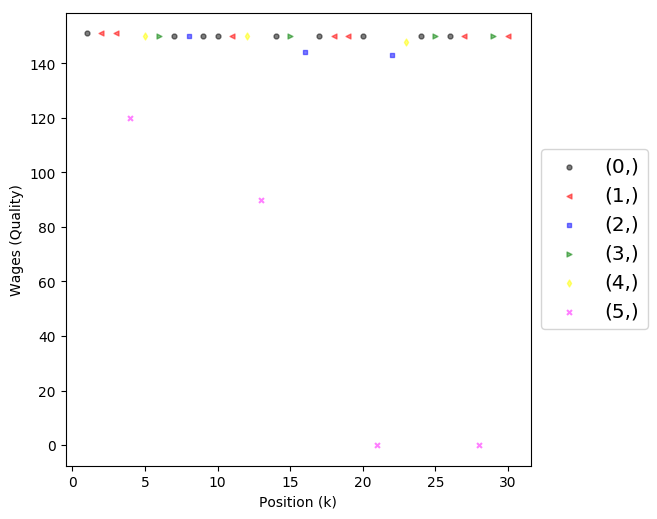

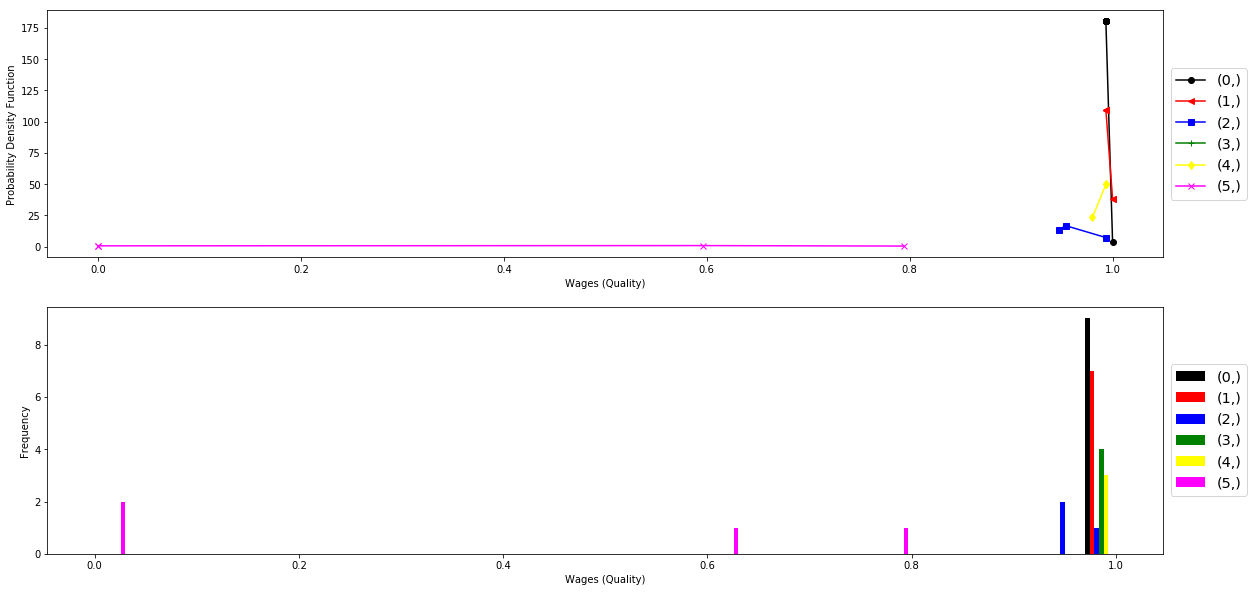

In [43]:
# json_data = open('ranking_algorithm_py/test_data_set_500.json').read()
# data = numpy.array(json_data.split("\n"))
# data_set = []
# for i in data:
#     data_set.append(ast.literal_eval(i))
# attribute = {"Gender":4}  


# json_data = open('test_data_set_two_attr.json').read()
# data = numpy.array(json_data.split("\n"))
# data_set = []
# for i in data:
#     data_set.append(ast.literal_eval(i))
# attribute = {"attr1": 2, "attr2":3}   
# test_ranking = generate_ranking(data_set, attribute, 'Quality',30, [0.3,0.2,0.2, 0.1,0.1,0.1], 0.1,False)      

# test_ranking = generate_ranking(data_set, attribute, 'Uni score',100, [0.4,0.3,0.2, 0.1], 0.1, True)

# json_data = open('test_data_set_sample2.json').read()
# data = numpy.array(json_data.split("\n"))
# data_set = []
# for i in data:
#     data_set.append(ast.literal_eval(i))
# data_set    
# attribute = {"Group":3}  

# test_ranking = generate_ranking(data_set, attribute, 'Quality',50, [0.4,0.3,0.3], 0.1, False)

json_data = open('soap_data.json').read()
data = numpy.array(json_data.split("\n"))
data_set = []
for i in data:
    data_set.append(ast.literal_eval(i))
attribute = {'Group':6}  

test_ranking = generate_ranking(data_set, {'Group':6}, 'Wages',30, [0.4,0.2,0.1,0.1,0.1,0.1], 0.1, False)

{'Credit': 18424, 'Group': 1}
1 :  [0, 1, 0, 0] Minimum Target:  [ 0.  0.  0.]
CDF:  0.712219218827
{'Credit': 15945, 'Group': 0}
2 :  [1, 1, 0, 0] Minimum Target:  [ 0.  0.  0.]
CDF:  0.420548415296
{'Credit': 15857, 'Group': 2}
3 :  [1, 1, 1, 0] Minimum Target:  [ 0.  0.  0.]
CDF:  0.462122922938
{'Credit': 15672, 'Group': 0}
4 :  [2, 1, 1, 0] Minimum Target:  [ 0.  0.  0.]
CDF:  0.279953075231
{'Credit': 15653, 'Group': 0}
5 :  [3, 1, 1, 0] Minimum Target:  [ 0.  0.  0.]
CDF:  0.156660082998
{'Credit': 14896, 'Group': 0}
6 :  [4, 1, 1, 0] Minimum Target:  [ 0.  0.  0.]
CDF:  0.082623748441
{'Credit': 14782, 'Group': 1}
7 :  [4, 2, 1, 0] Minimum Target:  [ 0.  0.  0.]
CDF:  0.113512148742
{'Credit': 14555, 'Group': 0}
8 :  [5, 2, 1, 0] Minimum Target:  [ 0.  0.  0.]
CDF:  0.0639461767548
{'Credit': 14421, 'Group': 0}
9 :  [6, 2, 1, 0] Minimum Target:  [ 0.  0.  0.]
CDF:  0.0345866801534
{'Credit': 14318, 'Group': 0}
10 :  [7, 2, 1, 0] Minimum Target:  [ 0.  0.  0.]
CDF:  0.0181066618

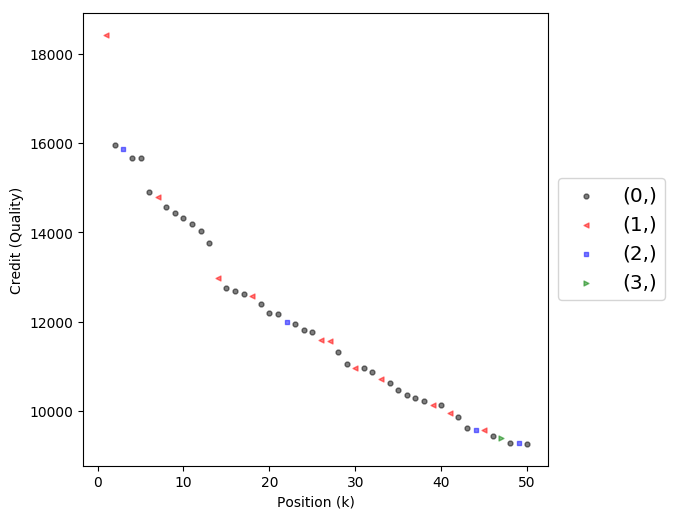

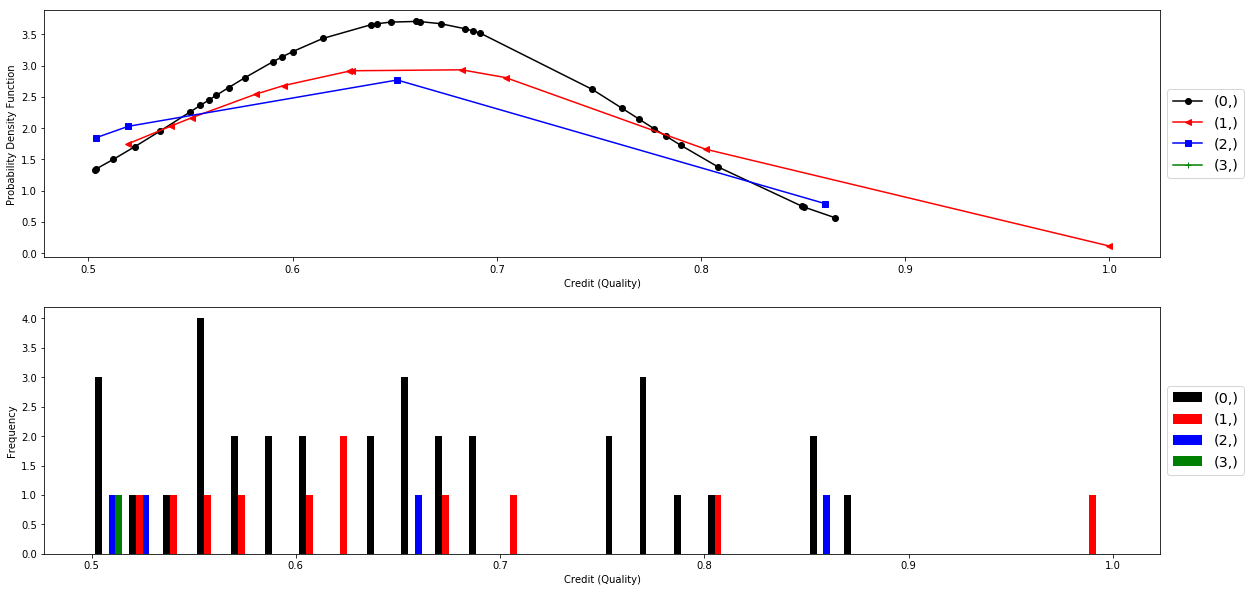

{'Credit': 1.0, 'k': 1, 'Group': 1, 'Utility': 0.91023922662683732}
{'Credit': 0.865447242726878, 'k': 2, 'Group': 0, 'Utility': 0.62428822261654693}
{'Credit': 0.860670864090317, 'k': 3, 'Group': 2, 'Utility': 0.53476487501692171}
{'Credit': 0.8506296135475466, 'k': 4, 'Group': 0, 'Utility': 0.47474542658006652}
{'Credit': 0.8495983499782892, 'k': 5, 'Group': 0, 'Utility': 0.43660718373391816}
{'Credit': 0.8085106382978723, 'k': 6, 'Group': 0, 'Utility': 0.38881142945943692}
{'Credit': 0.8023230568823274, 'k': 7, 'Group': 1, 'Utility': 0.36515295940072484}
{'Credit': 0.7900021710811984, 'k': 8, 'Group': 0, 'Utility': 0.34309358359215314}
{'Credit': 0.782729049066435, 'k': 9, 'Group': 0, 'Utility': 0.32642336716940162}
{'Credit': 0.7771385149804603, 'k': 10, 'Group': 0, 'Utility': 0.3127435451334809}
{'Credit': 0.7695940078158923, 'k': 11, 'Group': 0, 'Utility': 0.30004257416510527}
{'Credit': 0.7613438992618324, 'k': 12, 'Group': 0, 'Utility': 0.28849085266852725}
{'Credit': 0.7466348

In [69]:
json_data = open('credit_data.json').read()
data = numpy.array(json_data.split("\n"))
data_set = []
for i in data:
    data_set.append(ast.literal_eval(i))
attribute = {'Group':4}  

test_ranking = generate_ranking(data_set, attribute, 'Credit',50, [0.4,0.3,0.2,0.1], 0.1,True)

group 0:  138
group 1:  120
group 2:  128
group 3:  114
{'Quality': 3.5648343071, 'Group': 0, 'Index': 113}
1 :  [1, 0, 0, 0] Minimum Target:  [ 0.  0.  0.]
CDF:  0.311873823302
{'Quality': 2.0584406803, 'Group': 1, 'Index': 197}
Minimum achieved?  True
2 :  [1, 1, 0, 0] Minimum Target:  [ 1.  0.  0.]
CDF:  0.294577331536
{'Quality': 3.1990145925999998, 'Group': 0, 'Index': 486}
3 :  [2, 1, 0, 0] Minimum Target:  [ 1.  0.  0.]
CDF:  0.111084122369
{'Quality': 2.0229596358, 'Group': 1, 'Index': 83}
-------------------------------------------
[array([ 0.,  0.,  0.]), array([ 1.,  0.,  0.]), array([ 1.,  0.,  0.]), array([ 2.,  0.,  1.]), array([ 2.,  0.,  1.]), array([ 2.,  1.,  1.]), array([ 2.,  1.,  1.]), array([ 2.,  1.,  2.]), array([ 2.,  2.,  2.]), array([ 3.,  2.,  2.]), array([ 3.,  2.,  2.]), array([ 4.,  2.,  2.]), array([ 4.,  2.,  3.]), array([ 4.,  3.,  3.]), array([ 4.,  3.,  3.]), array([ 5.,  3.,  3.]), array([ 5.,  3.,  4.]), array([ 5.,  3.,  4.]), array([ 5.,  4.,  4.

30 :  [9, 9, 6, 6] Minimum Target:  [ 9.  6.  6.]
CDF:  0.124751720295
{'Quality': 1.4211561531, 'Group': 3, 'Index': 102}
Minimum achieved?  True
31 :  [9, 9, 6, 7] Minimum Target:  [ 9.  6.  7.]
CDF:  0.135237032396
{'Quality': 1.694092017, 'Group': 2, 'Index': 411}
Minimum achieved?  True
32 :  [9, 9, 7, 7] Minimum Target:  [ 9.  7.  7.]
CDF:  0.15065051349
{'Quality': 2.6730000394, 'Group': 0, 'Index': 150}
33 :  [10, 9, 7, 7] Minimum Target:  [ 9.  7.  7.]
CDF:  0.111787799675
{'Quality': 1.8387834574, 'Group': 1, 'Index': 93}
Minimum achieved?  True
34 :  [10, 10, 7, 7] Minimum Target:  [ 10.   7.   7.]
CDF:  0.129702980162
{'Quality': 1.8373320134000002, 'Group': 1, 'Index': 152}
Minimum achieved?  True
35 :  [10, 11, 7, 7] Minimum Target:  [ 11.   7.   7.]
CDF:  0.142144635103
{'Quality': 2.6504289328, 'Group': 0, 'Index': 169}
36 :  [11, 11, 7, 7] Minimum Target:  [ 11.   7.   7.]
CDF:  0.106516902414
{'Quality': 1.399120006, 'Group': 3, 'Index': 300}
Minimum achieved?  True
3

107 :  [31, 32, 22, 22] Minimum Target:  [ 32.  22.  22.]
CDF:  0.114452344028
{'Quality': 1.6969224984000002, 'Group': 1, 'Index': 92}
Minimum achieved?  True
108 :  [31, 33, 22, 22] Minimum Target:  [ 33.  22.  22.]
CDF:  0.121925636742
{'Quality': 2.1957459425, 'Group': 0, 'Index': 78}
109 :  [32, 33, 22, 22] Minimum Target:  [ 33.  22.  22.]
CDF:  0.10269701254
{'Quality': 1.3019203691, 'Group': 3, 'Index': 41}
Minimum achieved?  True
110 :  [32, 33, 22, 23] Minimum Target:  [ 33.  22.  23.]
CDF:  0.109747849226
{'Quality': 1.5236868339, 'Group': 2, 'Index': 473}
Minimum achieved?  True
111 :  [32, 33, 23, 23] Minimum Target:  [ 33.  23.  23.]
CDF:  0.118221355159
{'Quality': 1.6826414725, 'Group': 1, 'Index': 356}
Minimum achieved?  True
112 :  [32, 34, 23, 23] Minimum Target:  [ 34.  23.  23.]
CDF:  0.126527041802
{'Quality': 2.1917261697, 'Group': 0, 'Index': 382}
113 :  [33, 34, 23, 23] Minimum Target:  [ 34.  23.  23.]
CDF:  0.107094743076
{'Quality': 1.5098518189, 'Group': 2,

187 :  [54, 57, 38, 38] Minimum Target:  [ 57.  38.  38.]
CDF:  0.116020971789
{'Quality': 1.9660213852, 'Group': 0, 'Index': 231}
188 :  [55, 57, 38, 38] Minimum Target:  [ 57.  38.  38.]
CDF:  0.10167934094
{'Quality': 1.1992096787, 'Group': 3, 'Index': 344}
Minimum achieved?  True
189 :  [55, 57, 38, 39] Minimum Target:  [ 57.  38.  39.]
CDF:  0.107404861319
{'Quality': 1.3629330949, 'Group': 2, 'Index': 224}
Minimum achieved?  True
190 :  [55, 57, 39, 39] Minimum Target:  [ 57.  39.  39.]
CDF:  0.113983791468
{'Quality': 1.6137610842, 'Group': 1, 'Index': 450}
Minimum achieved?  True
191 :  [55, 58, 39, 39] Minimum Target:  [ 58.  39.  39.]
CDF:  0.119867227325
{'Quality': 1.9610404762, 'Group': 0, 'Index': 255}
192 :  [56, 58, 39, 39] Minimum Target:  [ 58.  39.  39.]
CDF:  0.105323939037
{'Quality': 1.1908373353, 'Group': 3, 'Index': 220}
Minimum achieved?  True
193 :  [56, 58, 39, 40] Minimum Target:  [ 58.  39.  40.]
CDF:  0.110813203613
{'Quality': 1.3605019973, 'Group': 2, 'I

254 :  [74, 76, 52, 52] Minimum Target:  [ 76.  52.  52.]
CDF:  0.107292570265
{'Quality': 1.5362449302, 'Group': 1, 'Index': 213}
Minimum achieved?  True
255 :  [74, 77, 52, 52] Minimum Target:  [ 77.  52.  52.]
CDF:  0.112449107367
{'Quality': 1.7527377617000002, 'Group': 0, 'Index': 278}
256 :  [75, 77, 52, 52] Minimum Target:  [ 77.  52.  52.]
CDF:  0.100295323117
{'Quality': 1.2986643211, 'Group': 2, 'Index': 334}
Minimum achieved?  True
257 :  [75, 77, 53, 52] Minimum Target:  [ 77.  53.  52.]
CDF:  0.104854046109
{'Quality': 1.1155244176, 'Group': 3, 'Index': 420}
Minimum achieved?  True
258 :  [75, 77, 53, 53] Minimum Target:  [ 77.  53.  53.]
CDF:  0.109996628644
{'Quality': 1.5358733698, 'Group': 1, 'Index': 485}
Minimum achieved?  True
259 :  [75, 78, 53, 53] Minimum Target:  [ 78.  53.  53.]
CDF:  0.115520755851
{'Quality': 1.7454495415000002, 'Group': 0, 'Index': 367}
260 :  [76, 78, 53, 53] Minimum Target:  [ 78.  53.  53.]
CDF:  0.103222569131
{'Quality': 1.5357320335, '

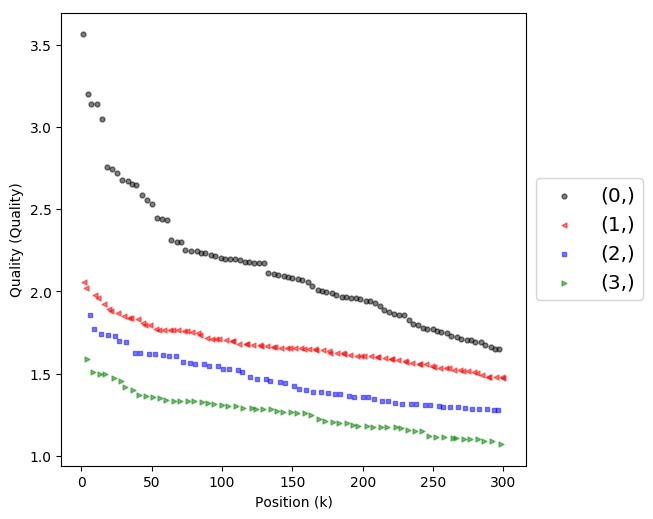

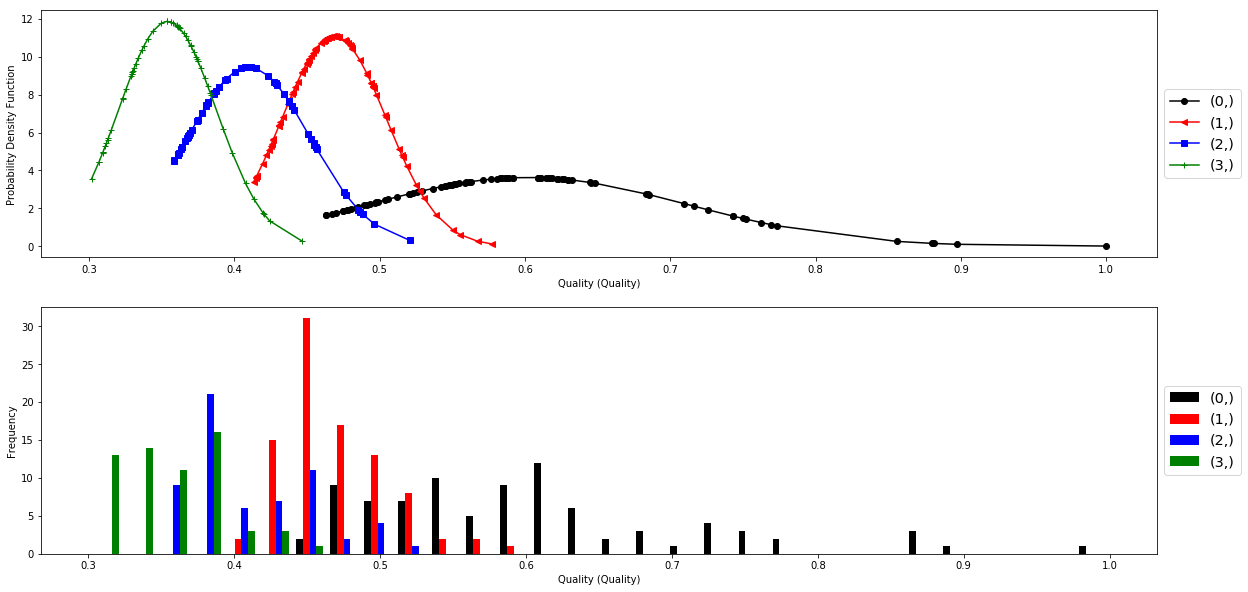

{'Quality': 1.0, 'k': 1, 'Utility': 0.91023922662683732, 'Group': 0, 'Index': 113}
{'Quality': 0.5774295529529241, 'k': 2, 'Utility': 0.4165273762539573, 'Group': 1, 'Index': 197}
{'Quality': 0.5674764832045397, 'k': 3, 'Utility': 0.35259296355601133, 'Group': 1, 'Index': 83}
{'Quality': 0.4466567918258464, 'k': 4, 'Utility': 0.24928390193929312, 'Group': 3, 'Index': 417}
{'Quality': 0.8973810048418225, 'k': 5, 'Utility': 0.46116261086231386, 'Group': 0, 'Index': 486}
{'Quality': 0.5209135672593572, 'k': 6, 'Utility': 0.25050647340561805, 'Group': 2, 'Index': 202}
{'Quality': 0.8814003593496779, 'k': 7, 'Utility': 0.40114259072153363, 'Group': 0, 'Index': 85}
{'Quality': 0.4243094610000255, 'k': 8, 'Utility': 0.18427525753165408, 'Group': 3, 'Index': 262}
{'Quality': 0.4965353593502506, 'k': 9, 'Utility': 0.20707132833653252, 'Group': 2, 'Index': 424}
{'Quality': 0.555524331875896, 'k': 10, 'Utility': 0.22355943710130541, 'Group': 1, 'Index': 438}
{'Quality': 0.8804091067147484, 'k': 1

{'Quality': 0.49756145450219486, 'k': 246, 'Utility': 0.09024537677181145, 'Group': 0, 'Index': 140}
{'Quality': 0.31545953136173466, 'k': 247, 'Utility': 0.057174848119476381, 'Group': 3, 'Index': 99}
{'Quality': 0.3676878546611314, 'k': 248, 'Utility': 0.066592494292885399, 'Group': 2, 'Index': 199}
{'Quality': 0.4333794704351352, 'k': 249, 'Utility': 0.078433293199531309, 'Group': 1, 'Index': 270}
{'Quality': 0.49714609612297067, 'k': 250, 'Utility': 0.089909118691079259, 'Group': 0, 'Index': 194}
{'Quality': 0.4318202897773049, 'k': 251, 'Utility': 0.07803901942145916, 'Group': 1, 'Index': 304}
{'Quality': 0.31330825987494326, 'k': 252, 'Utility': 0.056581063155437358, 'Group': 3, 'Index': 101}
{'Quality': 0.4935615771526079, 'k': 253, 'Utility': 0.089070222545875474, 'Group': 0, 'Index': 275}
{'Quality': 0.366360687142973, 'k': 254, 'Utility': 0.066068343314730021, 'Group': 2, 'Index': 53}
{'Quality': 0.430944273381878, 'k': 255, 'Utility': 0.0776605450689212, 'Group': 1, 'Index':

In [46]:
group_0=0
group_1=0
group_2=0
group_3=0
# json_data = open('test_data_set_sample2.json').read()
json_data = open('test_data_set_sample_500.json').read()
data = numpy.array(json_data.split("\n"))
data_set = []
for i in data:
    data_set.append(ast.literal_eval(i))
minima = [h['Quality'] for h in data_set]    
lower_bound = min(minima)
for j in range(len(data_set)):
    data_set[j]['Index']=j+1  
    data_set[j]['Quality'] = data_set[j]['Quality']-lower_bound
    if(data_set[j]['Group']== 2):
        data_set[j]['Group']=3
    elif(data_set[j]['Group']==3):
        data_set[j]['Group']=2

    if(data_set[j]['Group']==0):
        group_0 = group_0+1
    elif(data_set[j]['Group']==1):
        group_1 = group_1+1    
    elif(data_set[j]['Group']==2):
        group_2 = group_2+1 
    elif(data_set[j]['Group']==3):
        group_3 = group_3+1     

print "group 0: ",group_0
print "group 1: ",group_1
print "group 2: ",group_2
print "group 3: ",group_3

attribute = {"Group":4}  

test_ranking_syn, rest_syn = generate_ranking(data_set, attribute, 'Quality',300, [0.3,0.3,0.2,0.2], 0.1, False)

In [47]:
qual = 0
ndcg = 0

quality_cal = []
maxima=[]
upto_now=[]
for i in range(len(test_ranking_syn)):   
    maxima.append(test_ranking_syn[i]['Utility'])
    upto_now.append(test_ranking_syn[i]['Quality'])
    mini = min(upto_now)
    if(mini<test_ranking_syn[i]['Quality']):
        quality_cal.append(mini-test_ranking_syn[i]['Quality']) 
    ndcg = ndcg+test_ranking_syn[i]['Utility']
print "ndcf: ",ndcg
# print quality_cal
print "mini: ",min(quality_cal)
print "max_out: ",max(rest_syn)
print (1.0/numpy.log(1+301))*max(rest_syn)
print "min_in: ",min(maxima)

group_0=0
group_1=0
group_2=0
group_3=0

for j in range(len(test_ranking_syn)):
    if(test_ranking_syn[j]['Group']==0):
        group_0 = group_0+1
    elif(test_ranking_syn[j]['Group']==1):
        group_1 = group_1+1    
    elif(test_ranking_syn[j]['Group']==2):
        group_2 = group_2+1    
    elif(test_ranking_syn[j]['Group']==3):
        group_3 = group_3+1    

print "group 0: ",group_0
print "group 1: ",group_1
print "group 2: ",group_2
print "group 3: ",group_3

ndcf:  32.9476631162
mini:  -0.456099645715
max_out:  0.462591502476
0.0810082155097
min_in:  0.0529382728226
group 0:  87
group 1:  91
group 2:  61
group 3:  61


group 0:  200
group 1:  99
group 2:  59
group 3:  18
{'Index': 296, 'Group': 0, 'Math': 5}
1 :  [1, 0, 0, 0] Minimum Target:  [ 0.  0.  0.]
CDF:  0.609689136836
{'Index': 271, 'Group': 0, 'Math': 5}
2 :  [2, 0, 0, 0] Minimum Target:  [ 0.  0.  0.]
CDF:  0.234052867664
{'Index': 263, 'Group': 0, 'Math': 5}
3 :  [3, 0, 0, 0] Minimum Target:  [ 0.  0.  0.]
CDF:  0.104237265249
{'Index': 110, 'Group': 2, 'Math': 5}
Minimum achieved?  True
4 :  [3, 0, 1, 0] Minimum Target:  [ 0.  1.  0.]
CDF:  0.158266770542
{'Index': 370, 'Group': 1, 'Math': 5}
Minimum achieved?  True
5 :  [3, 1, 1, 0] Minimum Target:  [ 1.  1.  0.]
CDF:  0.261522175935
{'Index': 243, 'Group': 0, 'Math': 5}
6 :  [4, 1, 1, 0] Minimum Target:  [ 1.  1.  0.]
CDF:  0.168297667798
{'Index': 206, 'Group': 0, 'Math': 5}
7 :  [5, 1, 1, 0] Minimum Target:  [ 1.  1.  0.]
CDF:  0.104848997901
{'Index': 233, 'Group': 3, 'Math': 5}
Minimum achieved?  True
8 :  [5, 1, 1, 1] Minimum Target:  [ 1.  1.  1.]
CDF:  0.151179034351
{'Index': 7

73 :  [37, 14, 14, 8] Minimum Target:  [ 14.  14.   8.]
CDF:  0.120134131503
{'Index': 170, 'Group': 0, 'Math': 4}
74 :  [38, 14, 14, 8] Minimum Target:  [ 14.  14.   8.]
CDF:  0.103211269078
{'Index': 238, 'Group': 1, 'Math': 4}
Minimum achieved?  True
75 :  [38, 15, 14, 8] Minimum Target:  [ 15.  14.   8.]
CDF:  0.118788533242
{'Index': 163, 'Group': 0, 'Math': 4}
76 :  [39, 15, 14, 8] Minimum Target:  [ 15.  14.   8.]
CDF:  0.102276999596
{'Index': 82, 'Group': 2, 'Math': 4}
Minimum achieved?  True
77 :  [39, 15, 15, 8] Minimum Target:  [ 15.  15.   8.]
CDF:  0.120092715517
{'Index': 160, 'Group': 0, 'Math': 4}
78 :  [40, 15, 15, 8] Minimum Target:  [ 15.  15.   8.]
CDF:  0.103642336576
{'Index': 45, 'Group': 2, 'Math': 4}
Minimum achieved?  True
79 :  [40, 15, 16, 8] Minimum Target:  [ 15.  16.   8.]
CDF:  0.117702357201
{'Index': 157, 'Group': 0, 'Math': 4}
80 :  [41, 15, 16, 8] Minimum Target:  [ 15.  16.   8.]
CDF:  0.101768827795
{'Index': 234, 'Group': 1, 'Math': 4}
Minimum ac

CDF:  0.106768727956
{'Index': 123, 'Group': 2, 'Math': 3}
Minimum achieved?  True
164 :  [82, 32, 33, 17] Minimum Target:  [ 32.  33.  17.]
CDF:  0.117188923401
{'Index': 215, 'Group': 0, 'Math': 3}
165 :  [83, 32, 33, 17] Minimum Target:  [ 32.  33.  17.]
CDF:  0.105912512606
{'Index': 361, 'Group': 1, 'Math': 3}
Minimum achieved?  True
166 :  [83, 33, 33, 17] Minimum Target:  [ 33.  33.  17.]
CDF:  0.117318061291
{'Index': 214, 'Group': 0, 'Math': 3}
167 :  [84, 33, 33, 17] Minimum Target:  [ 33.  33.  17.]
CDF:  0.106109840712
{'Index': 231, 'Group': 3, 'Math': 1}
Minimum achieved?  True
168 :  [84, 33, 33, 18] Minimum Target:  [ 33.  33.  18.]
CDF:  0.116903030552
{'Index': 212, 'Group': 0, 'Math': 3}
169 :  [85, 33, 33, 18] Minimum Target:  [ 33.  33.  18.]
CDF:  0.105714349994
{'Index': 355, 'Group': 1, 'Math': 3}
Minimum achieved?  True
170 :  [85, 34, 33, 18] Minimum Target:  [ 34.  33.  18.]
CDF:  0.116387148596
{'Index': 211, 'Group': 0, 'Math': 3}
171 :  [86, 34, 33, 18] Mi

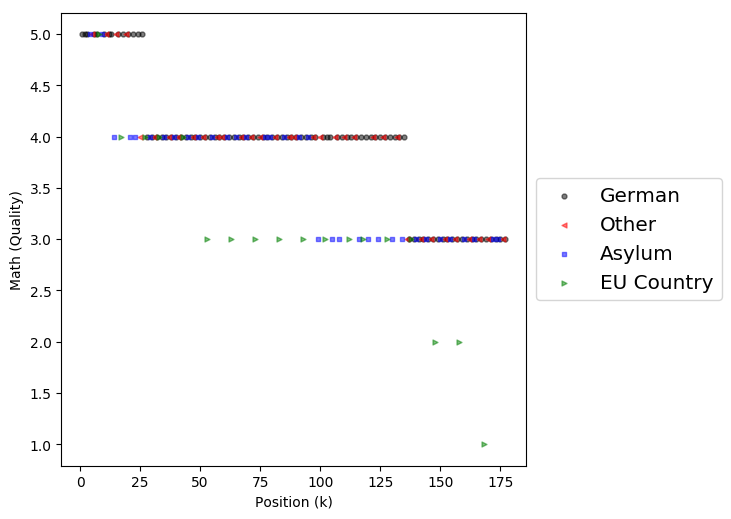

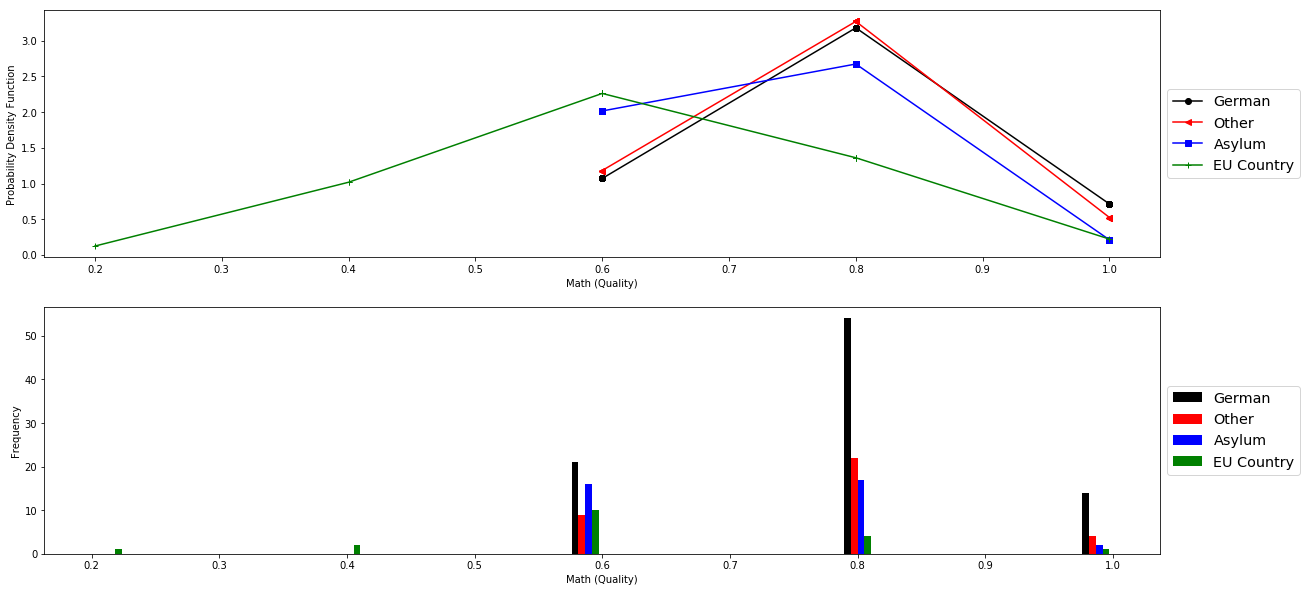

{'Index': 296, 'k': 1, 'Group': 0, 'Math': 1.0, 'Utility': 0.91023922662683732}
{'Index': 271, 'k': 2, 'Group': 0, 'Math': 1.0, 'Utility': 0.72134752044448169}
{'Index': 263, 'k': 3, 'Group': 0, 'Math': 1.0, 'Utility': 0.62133493455961186}
{'Index': 110, 'k': 4, 'Group': 2, 'Math': 1.0, 'Utility': 0.55811062655124721}
{'Index': 370, 'k': 5, 'Group': 1, 'Math': 1.0, 'Utility': 0.51389834236975074}
{'Index': 243, 'k': 6, 'Group': 0, 'Math': 1.0, 'Utility': 0.48089834696298783}
{'Index': 206, 'k': 7, 'Group': 0, 'Math': 1.0, 'Utility': 0.45511961331341866}
{'Index': 233, 'k': 8, 'Group': 3, 'Math': 1.0, 'Utility': 0.43429448190325176}
{'Index': 79, 'k': 9, 'Group': 2, 'Math': 1.0, 'Utility': 0.41703239142424631}
{'Index': 204, 'k': 10, 'Group': 0, 'Math': 1.0, 'Utility': 0.40242960438184466}
{'Index': 328, 'k': 11, 'Group': 1, 'Math': 1.0, 'Utility': 0.38987124525128009}
{'Index': 164, 'k': 12, 'Group': 0, 'Math': 1.0, 'Utility': 0.37892318168995121}
{'Index': 155, 'k': 13, 'Group': 0, 'M

In [60]:
# json_data = open('math_migration_data.json').read()
json_data = open('math_note.json').read()
data = numpy.array(json_data.split("\n"))
data_set = []
group_0=0
group_1=0
group_2=0
group_3=0
for i in data:
    data_set.append(ast.literal_eval(i))
for j in range(len(data_set)):
    data_set[j]['Index']=j+1
    if(data_set[j]['Group']==0):
        group_0 = group_0+1
    elif(data_set[j]['Group']==1):
        group_1 = group_1+1    
    elif(data_set[j]['Group']==2):
        group_2 = group_2+1    
    elif(data_set[j]['Group']==3):
        group_3 = group_3+1    

print "group 0: ",group_0
print "group 1: ",group_1
print "group 2: ",group_2
print "group 3: ",group_3
test_ranking_math, rest_math = generate_ranking(data_set, {"Group":4}, 'Math',376, [0.5,0.2,0.2,0.1], 0.1, False)

In [59]:
qual = 0
ndcg = 0
quality = 1.0
quality_cal = []
maxima=[]
for i in range(len(test_ranking_math)):   
    maxima.append(test_ranking_math[i]['Utility'])
    if(quality<test_ranking_math[i]['Math']):
        quality_cal.append(quality-test_ranking_math[i]['Math'])
    quality = test_ranking_math[i]['Math']  
    ndcg = ndcg+test_ranking_math[i]['Utility']
print ndcg
# print quality_cal
print min(quality_cal)
print "max_out: ",(1.0/numpy.log(1+151))*max(rest_math)
print max(rest_math)
print "min_in: ",min(maxima)

group_0=0
group_1=0
group_2=0
group_3=0

for j in range(len(test_ranking_math)):
    if(test_ranking_math[j]['Group']==0):
        group_0 = group_0+1
    elif(test_ranking_math[j]['Group']==1):
        group_1 = group_1+1    
    elif(test_ranking_math[j]['Group']==2):
        group_2 = group_2+1    
    elif(test_ranking_math[j]['Group']==3):
        group_3 = group_3+1    

print "group 0: ",group_0
print "group 1: ",group_1
print "group 2: ",group_2
print "group 3: ",group_3

31.9241378992
-0.2
max_out:  0.119429591829
0.6
min_in:  0.0798301964765
group 0:  75
group 1:  29
group 2:  30
group 3:  16


{'Group': 0, 'Math': 6}
1 :  [1, 0, 0, 0, 0] Minimum Target:  [ 0.  0.  0.  0.]
CDF:  0.489076210108
{'Group': 0, 'Math': 6}
2 :  [2, 0, 0, 0, 0] Minimum Target:  [ 0.  0.  0.  0.]
CDF:  0.143143629273
{'Group': 2, 'Math': 6}
Minimum achieved?  True
3 :  [2, 0, 1, 0, 0] Minimum Target:  [ 0.  1.  0.  0.]
CDF:  0.162375286614
{'Group': 1, 'Math': 6}
Minimum achieved?  True
4 :  [2, 1, 1, 0, 0] Minimum Target:  [ 1.  1.  0.  0.]
CDF:  0.212129773695
{'Group': 3, 'Math': 6}
5 :  [2, 1, 1, 1, 0] Minimum Target:  [ 1.  1.  0.  0.]
CDF:  0.222602265947
{'Group': 4, 'Math': 6}
Minimum achieved?  True
6 :  [2, 1, 1, 1, 1] Minimum Target:  [ 1.  1.  0.  1.]
CDF:  0.264306040217
{'Group': 4, 'Math': 6}
7 :  [2, 1, 1, 1, 2] Minimum Target:  [ 1.  1.  1.  1.]
CDF:  0.211775319788
{'Group': 2, 'Math': 5}
Minimum achieved?  True
8 :  [2, 1, 2, 1, 2] Minimum Target:  [ 1.  2.  1.  1.]
CDF:  0.253778627776
{'Group': 4, 'Math': 6}
9 :  [2, 1, 2, 1, 3] Minimum Target:  [ 1.  2.  1.  1.]
CDF:  0.19156209

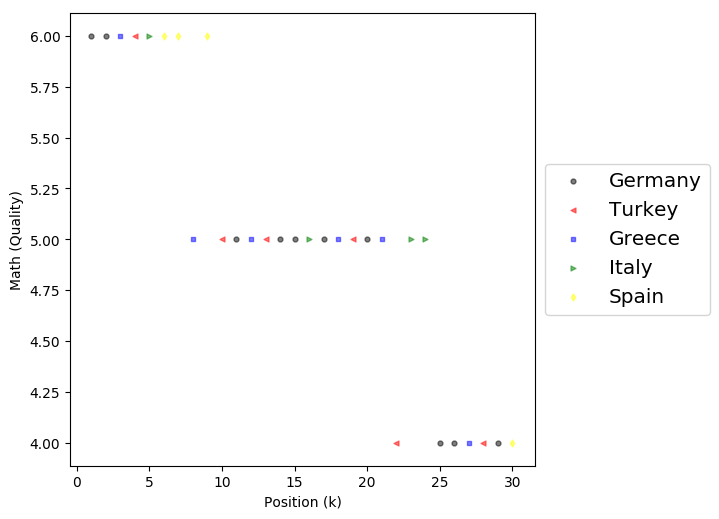

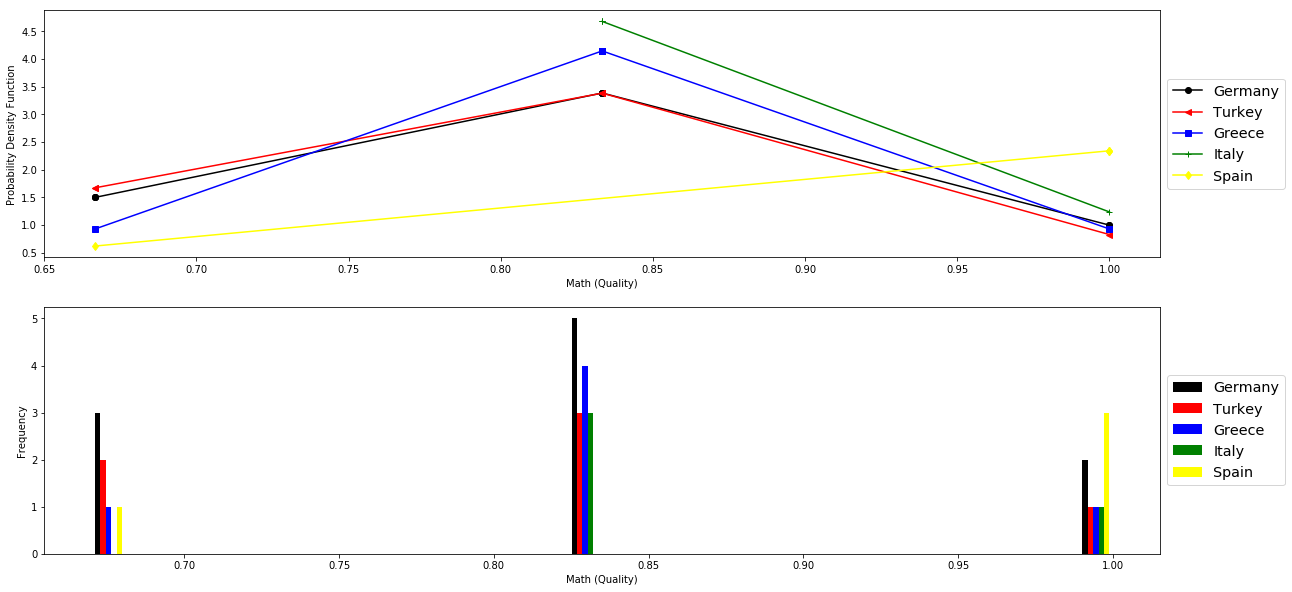

In [9]:
json_data = open('math_nationality_data.json').read()
data = numpy.array(json_data.split("\n"))
data_set = []
for i in data:
    data_set.append(ast.literal_eval(i))
attribute = {"Group":5}  

test_ranking = generate_ranking(data_set, attribute, 'Math',30, [0.4,0.2,0.2,0.1,0.1], 0.1, False)